# Developing an AI application

In this project, we'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content


In [1]:
# Imports 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np

import torch
import torchvision

import json
import time
import os
import copy
import warnings

from torch import nn, optim
from torch.optim import lr_scheduler

import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms, models

from PIL import Image


## Load the data

Here we'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, we'll apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. We'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks we'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets we'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
!wget https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz

--2022-03-09 19:22:19--  https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.13.230
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.13.230|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344873452 (329M) [application/x-gzip]
Saving to: ‘flower_data.tar.gz’

flower_data.tar.gz  100%[===================>] 328.90M  22.9MB/s    in 17s     

2022-03-09 19:22:37 (18.9 MB/s) - ‘flower_data.tar.gz’ saved [344873452/344873452]



In [ ]:
!tar xzvf flower_data.tar.gz -C flowers
!rm flower_data.tar.gz

In [4]:
data_dir = 'flowers'

In [5]:
# Define the transforms to normalize the data for the training, validation, and testing sets
data_transforms = {
    'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(30),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), 
                                                      (0.229, 0.224, 0.225))
                                ]),
    'test': transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), 
                                                     (0.229, 0.224, 0.225))
                               ]),
    
    'valid': transforms.Compose([transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), 
                                                      (0.229, 0.224, 0.225))
                                ]),
}

# Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in list(data_transforms.keys())
}

# Define the dataloaders
data_loaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
               for x in list(data_transforms.keys())
}

dataset_sizes = {x: len(image_datasets[x]) for x in list(image_datasets.keys())
}

### Label mapping

We'll also need to load in a mapping from category label to category name. We can find this in the file `cat_to_name.json`. It's a JSON object which we can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [6]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, we should use one of the pretrained models from `torchvision.models` to get the image features. 

Build and train a new feed-forward classifier using those features:

* Load a [pre-trained network](https://pytorch.org/vision/master/models.html) (The VGG networks work great and are straightforward to use as a starting point)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

In [7]:
# Build and train your network
# Load a vgg16 pre-trained network
model = models.vgg16(pretrained=True)

In [8]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
# Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
# Hyperparameters for our network
input_size = 25088
hidden_sizes = [4096, 1000]
output_size = 102
drop_p = 0.5

# Freeze layers so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

# Build a feed-forward network
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(drop_p)),
                          ('fc3', nn.Linear(hidden_sizes[1], output_size)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

print('Classifier:', classifier)

Classifier: Sequential(
  (fc1): Linear(in_features=25088, out_features=4096, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=4096, out_features=1000, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=1000, out_features=102, bias=True)
  (output): LogSoftmax(dim=1)
)


In [10]:
# Transfert learning
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print('Device = ', device)

# Create the network, define the criterion and optimizer
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epoch
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Device =  cuda:0


In [11]:
# Track the loss and accuracy on the validation set to determine the best hyperparameters
def train_model(model, criterion, optimizer, scheduler, epochs):
    print('Training..')
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch +1, epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase =='train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    # Return the model
    return model

In [12]:
model = train_model(model, criterion, optimizer, scheduler, epochs=10)

Training..
Epoch 1/10
----------
train Loss: 2.9623 Acc: 0.2929
valid Loss: 1.5917 Acc: 0.5929

Epoch 2/10
----------
train Loss: 1.8569 Acc: 0.5023
valid Loss: 1.0627 Acc: 0.7139

Epoch 3/10
----------
train Loss: 1.6229 Acc: 0.5705
valid Loss: 0.9245 Acc: 0.7506

Epoch 4/10
----------
train Loss: 1.4528 Acc: 0.6168
valid Loss: 0.7664 Acc: 0.7946

Epoch 5/10
----------
train Loss: 1.4089 Acc: 0.6306
valid Loss: 0.9385 Acc: 0.8056

Epoch 6/10
----------
train Loss: 1.3500 Acc: 0.6516
valid Loss: 0.7325 Acc: 0.8276

Epoch 7/10
----------
train Loss: 1.3338 Acc: 0.6583
valid Loss: 0.7766 Acc: 0.8020

Epoch 8/10
----------
train Loss: 0.9450 Acc: 0.7489
valid Loss: 0.5217 Acc: 0.8594

Epoch 9/10
----------
train Loss: 0.8058 Acc: 0.7834
valid Loss: 0.4602 Acc: 0.8888

Epoch 10/10
----------
train Loss: 0.7420 Acc: 0.7969
valid Loss: 0.4382 Acc: 0.8863

Training complete in 98m 56s
Best val Acc: 0.888753


## Testing your network

It's good practice to test our trained network on test data, images the network has never seen either in training or validation. This will give us a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. We should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [13]:
# Testing network
model.eval()

accuracy = 0

for inputs, labels in data_loaders['test']:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)

    # Class with the highest probability is our predicted class
    equality = (labels.data == outputs.max(1)[1])

    # Accuracy is number of correct predictions divided by all predictions
    accuracy += equality.type_as(torch.FloatTensor()).mean()

print("Test accuracy: {:.3f}".format(accuracy/len(data_loaders['test'])))
print("Test complete")

Test accuracy: 0.857
Test complete


## Save the checkpoint

Now that our network is trained, save the model so we can load it later for making predictions. 

In [14]:
# Temporarily Suppressing Warnings in the Notebook
# https://docs.python.org/3/library/warnings.html#overriding-the-default-filter
def deprecation(message):
    warnings.warn(message, DeprecationWarning, stacklevel=2)

In [16]:
# Save the checkpoint 
model.class_to_idx = image_datasets['train'].class_to_idx

checkpoint = {'arch': 'vgg16',
              'hidden_units':hidden_sizes[0],
              'optimizer': optimizer.state_dict(),
              'class_to_idx': model.class_to_idx,
              'state_dict': model.state_dict(),
              'model': model}

torch.save(checkpoint, 'checkpoint.pth')
print('Checkpoint saved')

Checkpoint saved


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way we can come back to this project and keep working on it without having to retrain the network.

In [17]:
# Function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model'] 
    arch = checkpoint['arch']
    hidden_sizes[0] = checkpoint['hidden_units']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])    
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model    

In [18]:
#Load network
model = load_checkpoint('checkpoint.pth')
print('Loaded model: ', model,'\n')    

Loaded model:  VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, paddin

In [19]:
# Invert the dictionary to get a mapping from index to class as well
invert = image_datasets['train'].class_to_idx 
model.class_to_idx = dict((value,key) for key,value in invert.items()) 

# Inference for classification

Now we'll write a function to use a trained network for inference.First we'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

We will use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then we'll crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. We'll convert the values. It's easiest with a Numpy array, which we can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. We will reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [20]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # Make tranformations resize, crop, center 
    resize_image = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor()])

    # Process a PIL image 
    pil_image = Image.open(image)
    pil_image = resize_image(pil_image).float()
    
    np_image = np.array(pil_image)
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # swap color axis because
    # numpy image: H x W x C
    # torch image: C X H X W
    np_image = (np_image.transpose((1, 2, 0)) - mean ) / std
    np_image = np_image.transpose((2, 0, 1))
    
    return np_image

In [21]:
# Test image
test_image = "flowers/test/35/image_06986.jpg"

The function below converts a PyTorch tensor and displays it in the notebook. If our `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [22]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

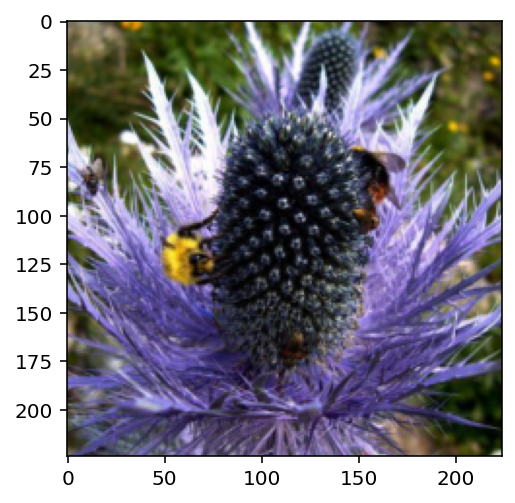

In [23]:
#Test process_image function
%matplotlib inline

_= imshow(process_image(test_image))

## Class Prediction

Once we can get images in the correct format, it's time to write a function for making predictions with our model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully we added to the model or from an `ImageFolder` we used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

In [24]:
image_datasets['train'].class_to_idx = model.class_to_idx

def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    
    '''
    model.eval()
    
    image = process_image(image_path)
    
    image = Variable(torch.FloatTensor(image), requires_grad=True)
    image = image.unsqueeze(0) 
    
    image = image.to(device)
    output = model(image).topk(topk)

    probs = F.softmax(output[0].data, dim=1).cpu().numpy()[0]
    classes = output[1].data.cpu().numpy()[0]
    classes = [model.class_to_idx[i] for i in classes.data]
        
    return probs, classes

In [25]:
probs, classes = predict(test_image, model, topk=5)

print('probs:', probs)
print('classes:', classes)

probs: [1.0000000e+00 3.2335660e-12 4.2156258e-13 2.3869278e-14 6.7620584e-15]
classes: ['35', '17', '10', '14', '100']


In [26]:
# Print names
classes = [cat_to_name[i] for i in classes]
print('classes:', classes)

classes: ['alpine sea holly', 'purple coneflower', 'globe thistle', 'spear thistle', 'blanket flower']


## Sanity Checking

Now that we can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs.

In [27]:
# Display an image along with the top 5 classes

''' Function for viewing an image and it's predicted classes.
'''
def sanity_checking(image):
    
    image = mpimg.imread(test_image)


    fig, axes = plt.subplots(2,1)

    axes[0].imshow(image)

    axes[0].set_title(classes[0])
    axes[0].axis('off')

    axes[1].barh(np.arange(len(classes)), probs, align='center')
    axes[1].set_aspect(0.1)
    axes[1].set_yticks(np.arange(len(classes)))
    axes[1].set_yticklabels(classes, size='large')
    axes[1].invert_yaxis()  
    axes[1].set_xlabel('Class Probability')
    axes[1].set_xlim(0, 1.1)

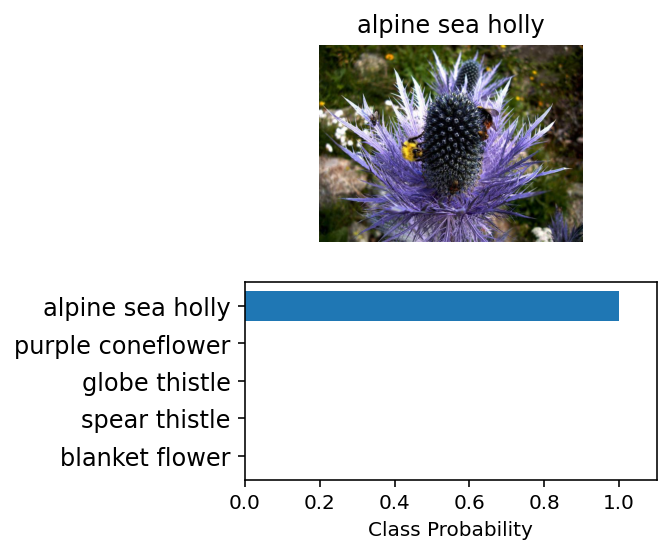

In [28]:
sanity_checking(test_image)